! pip3 install -U scikit-learn scipy matplotlib
! pip3 install -U shap 
! pip3 install -U lime 
! pip3 install -U xgboost 
! pip3 install -U eli5 
! pip3 install -U seaborn 

! pip3 install ipywidgets

! pip3 install lightgbm

! pip3 install mlxtend

! pip3 install -U catboost


In [91]:
import os

import numpy as np 
import pandas as pd 

import pickle

import itertools 

from eli5 import show_prediction, show_weights
from eli5.sklearn import PermutationImportance

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import xgboost as xgb 
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

import seaborn as sns 

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt 

from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier

import sys
sys.path.append('..')

from inxai import *
import shap
import lime

In [7]:
path = '../examples/'

def to_pickle(obj, name):
    with open(path + name + '.pickle', 'wb') as f:
        pickle.dump(obj, f)

def from_pickle(name):
    return pd.read_pickle(path + name + '.pickle')


In [48]:
def approximateAreaUnderTheCurveAccLoss(acc_loss): 
    acc_los_abs = [0 if value < 0 else value for value in acc_loss]
    return sum(acc_los_abs) / len(acc_los_abs) * 100

def AreaUnderTheCurve(acc_loss):
    l = len(acc_loss)
    return auc(np.linspace(0, 1, l), acc_loss)

In [9]:
df = pd.read_csv("../examples/data/compass/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")
print(df.shape)
display(df.columns)
df.head()

(6172, 12)


Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [10]:
TARGET_COL = "Two_yr_Recidivism"

X = df.drop([TARGET_COL],axis=1)
y = df[TARGET_COL]

FEATURE_IDS = [str(i) for i in range(X.shape[1])]

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)

print("TRAIN:")
print(X_train.head())
print("\nTEST:")
print(y_test.head())

TRAIN:
      Number_of_Priors  score_factor  Age_Above_FourtyFive  \
5025                 3             0                     0   
3098                 2             0                     0   
1187                 3             1                     0   
5238                 3             1                     1   
4270                 1             0                     1   

      Age_Below_TwentyFive  African_American  Asian  Hispanic  \
5025                     1                 0      0         0   
3098                     1                 1      0         0   
1187                     0                 1      0         0   
5238                     0                 0      0         1   
4270                     0                 1      0         0   

      Native_American  Other  Female  Misdemeanor  
5025                0      0       0            1  
3098                0      0       1            0  
1187                0      0       0            0  
5238                0

## Modele 
- svc_radial
- svc_lin
- xgbc
- lgbm
- rfc
- catboost

In [11]:
svc_radial = SVC(kernel='rbf',probability=True) # does not work with eli

svc_radial.fit(X_train, y_train)
svc_radial_preds = svc_radial.predict(X_test)

# to_pickle(svc_radial, 'model_svc_radial')

print(accuracy_score(y_test, svc_radial_preds))
print(classification_report(y_test, svc_radial_preds))

# show_prediction(svc_radial, X_train.iloc[1], feature_names = X.columns.tolist(), 
#                 show_feature_values=True)

0.658321060382916
              precision    recall  f1-score   support

           0       0.68      0.71      0.69      1118
           1       0.63      0.60      0.61       919

    accuracy                           0.66      2037
   macro avg       0.65      0.65      0.65      2037
weighted avg       0.66      0.66      0.66      2037



In [12]:
svc_lin = SVC(kernel='linear',probability=True) 
svc_lin.fit(X_train, y_train)
svc_lin_preds = svc_lin.predict(X_test)

# to_pickle(svc_lin, 'model_svc_lin')

print(accuracy_score(y_test, svc_lin_preds))
print(classification_report(y_test, svc_lin_preds))

show_prediction(svc_lin, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

0.6514482081492391
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1118
           1       0.61      0.61      0.61       919

    accuracy                           0.65      2037
   macro avg       0.65      0.65      0.65      2037
weighted avg       0.65      0.65      0.65      2037



In [13]:
xgbc = xgb.XGBClassifier() 
xgbc.fit(X_train, y_train)
xgbc_preds = xgbc.predict(X_test)

# to_pickle(xgbc, 'model_xgbc')

print(accuracy_score(y_test, xgbc_preds))
print(classification_report(y_test, xgbc_preds))

show_prediction(xgbc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

[21:47:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6666666666666666


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


              precision    recall  f1-score   support

           0       0.69      0.73      0.70      1118
           1       0.64      0.60      0.62       919

    accuracy                           0.67      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.67      0.67      0.67      2037



In [14]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 4, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4 }

lgbm = lgb.train(params,                                    # does not work with eli
                 lgb.Dataset(X_train,label=y_train),
#                  2500,
                 valid_sets=lgb.Dataset(X_test,label=y_test),
                 early_stopping_rounds= 15,
                 verbose_eval= 30
                 )

lgbm_preds = lgbm.predict(X_test)
lgbm_preds = (lgbm_preds > 0.5) * 1

# to_pickle(lgbm, 'model_lgbm')

print(accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

# show_prediction(lgbm, X_train.iloc[1], feature_names = X.columns.tolist(), #estimator is not supported
#                 show_feature_values=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 4135, number of used features: 11
[LightGBM] [Info] Start training from score 0.457074
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.720958
0.678939617083947
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      1118
           1       0.68      0.54      0.60       919

    accuracy                           0.68      2037
   macro avg       0.68      0.67      0.67      2037
weighted avg       0.68      0.68      0.67      2037



In [15]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

# to_pickle(rfc, 'model_rfc')

print(accuracy_score(y_test, rfc_preds))
print(classification_report(y_test, rfc_preds))

show_prediction(rfc, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

0.6642120765832106
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      1118
           1       0.64      0.60      0.62       919

    accuracy                           0.66      2037
   macro avg       0.66      0.66      0.66      2037
weighted avg       0.66      0.66      0.66      2037



In [16]:
ctb = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

ctb.fit(X_train, y_train)
ctb_preds = ctb.predict(X_test)

to_pickle(ctb, 'model_ctb')

print(accuracy_score(y_test, ctb_preds))
print(classification_report(y_test, ctb_preds))

# show_prediction(ctb, X_train.iloc[1], feature_names = X.columns.tolist(),  #estimator is not supported
#                 show_feature_values=True)

0.6696121747668139
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1118
           1       0.65      0.59      0.62       919

    accuracy                           0.67      2037
   macro avg       0.67      0.66      0.66      2037
weighted avg       0.67      0.67      0.67      2037



## LIME

In [17]:
# lime_svc_radial = generate_per_instance_importances(models=[svc_radial], X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_svc_radial, 'lime_svc_radial')
# lime_svc_radial

# lime_svc_lin = generate_per_instance_importances(models=svc_lin, X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_svc_lin, 'lime_svc_lin')
# lime_svc_lin

# lime_xgbc = generate_per_instance_importances(models=xgbc, X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_xgbc, 'lime_xgbc')
# lime_xgbc

# lime_lgbm = generate_per_instance_importances(models=lgbm, X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_lgbm, 'lime_lgbm')
# lime_lgbm

# lime_rfc = generate_per_instance_importances(models=rfc, X=X_test, y=y_test, framework='lime') # does not work 
# to_pickle(lime_rfc, 'lime_lgbm')
# lime_rfc

## SHAP's

In [18]:
gm = GlobalFeatureMetric()


In [19]:
# shap_svc_radial = generate_per_instance_importances(models=svc_radial, X=X_test.iloc[0:10, ], y=y_test.iloc[0:10, ], framework='kernel_shap') 
# to_pickle(shap_svc_radial, 'shap_svc_radial')
# print(len(shap_svc_radial))

# shap_svc_lin = generate_per_instance_importances(models=svc_lin, X=X_test.iloc[0:10, ], y=y_test.iloc[0:10, ], framework='kernel_shap') 
# to_pickle(shap_svc_lin, 'shap_svc_lin')
# print(len(shap_svc_lin))


# # shap_xgbc = generate_per_instance_importances(models=xgbc, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='kernel_shap') 
# # to_pickle(shap_xgbc, 'shap_xgbc')
# print(len(shap_xgbc))

# shap_xgbc_tree = generate_per_instance_importances(models=xgbc, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='tree_shap') 
# to_pickle(shap_xgbc_tree, 'shap_xgbc_tree')
# print(len(shap_xgbc_tree))


# # shap_lgbm = generate_per_instance_importances(models=lgbm, X=X_test.iloc[0:10, ], y=y_test.iloc[0:10, ], framework='tree_shap') # nie dziala
# # to_pickle(shap_lgbm, 'shap_lgbm')
# # print(len(shap_lgbm))

# shap_rfc = generate_per_instance_importances(models=rfc, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='tree_shap')  
# to_pickle(shap_rfc, 'shap_rfc')
# print(len(shap_rfc))

# shap_ctb = generate_per_instance_importances(models=ctb, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='tree_shap')  
# to_pickle(shap_ctb, 'shap_ctb')
# print(len(shap_ctb))


### SHAP's baseline

In [20]:
shap_svc_radial = from_pickle('shap_svc_radial')
print(len(shap_svc_radial))

shap_svc_lin = from_pickle('shap_svc_lin')
print(len(shap_svc_lin))

shap_xgbc = from_pickle('shap_xgbc')
print(len(shap_xgbc))

shap_rfc = from_pickle('shap_rfc')
print(len(shap_rfc))

shap_ctb = from_pickle('shap_ctb')
print(len(shap_ctb))


10
10
2037
2037
2037


In [21]:
# shap_tree_xgbc_rfc_ctb = generate_per_instance_importances(models=[xgbc, rfc, ctb], X=X_test, y=y_test, framework='tree_shap') 
# to_pickle(shap_tree_xgbc_rfc_ctb, 'shap_tree_xgbc_rfc_ctb')
shap_tree_xgbc_rfc_ctb = from_pickle('shap_tree_xgbc_rfc_ctb')
len(shap_tree_xgbc_rfc_ctb)

3

### Consistency per model

In [22]:
# shap_xgbc_rfc_ctb_consistency = gm.consistency([shap_xgbc, shap_rfc, shap_ctb]) # ! porownojemy spojnosc m. modelami (LIME(...) rzuca bledem)
# to_pickle(shap_xgbc_rfc_ctb_consistency, 'shap_xgbc_rfc_ctb_consistency')
shap_xgbc_rfc_ctb_consistency = from_pickle('shap_xgbc_rfc_ctb_consistency')
len(shap_xgbc_rfc_ctb_consistency)
# shap_xgbc_rfc_ctb_consistency

2037

In [23]:
shap_tree_xgbc_rfc_ctb_consistency = gm.consistency(shap_tree_xgbc_rfc_ctb)
len(shap_tree_xgbc_rfc_ctb_consistency)

2037

<AxesSubplot:xlabel='variable', ylabel='value'>

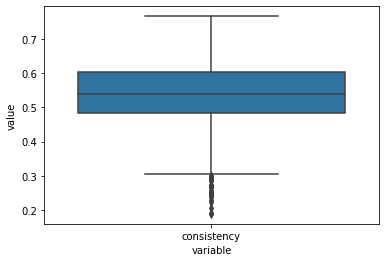

In [19]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'consistency':shap_xgbc_rfc_ctb_consistency})))

<AxesSubplot:xlabel='variable', ylabel='value'>

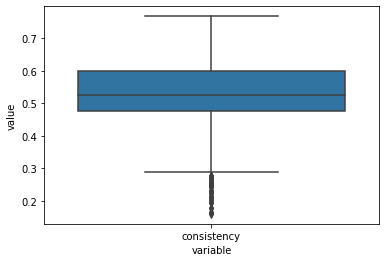

In [20]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'consistency':shap_tree_xgbc_rfc_ctb_consistency})))

In [24]:
shap_xgbc_rfc_consistency = gm.consistency([shap_xgbc, shap_rfc])
shap_xgbc_ctb_consistency = gm.consistency([shap_xgbc, shap_ctb])
shap_rfc_ctb_consistency = gm.consistency([shap_rfc, shap_ctb])

<AxesSubplot:xlabel='variable', ylabel='value'>

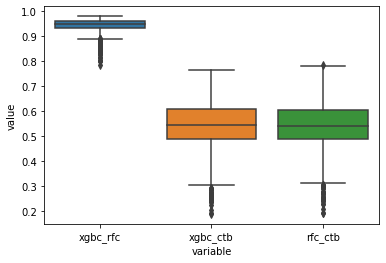

In [22]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'xgbc_rfc':shap_xgbc_rfc_consistency, 'xgbc_ctb':shap_xgbc_ctb_consistency, 'rfc_ctb':shap_rfc_ctb_consistency})))

In [41]:
# ctb - ???

### Stability

In [25]:
# shap_xgbc_stability = gm.stability(X_test, shap_xgbc ,epsilon=0.3)
# shap_rfc_stability = gm.stability(X_test, shap_rfc ,epsilon=0.3)
# shap_ctb_stability = gm.stability(X_test, shap_ctb ,epsilon=0.3)

# to_pickle(shap_xgbc_stability, 'shap_xgbc_stability')
# to_pickle(shap_rfc_stability, 'shap_rfc_stability')
# to_pickle(shap_ctb_stability, 'shap_ctb_stability')

shap_xgbc_stability = from_pickle('shap_xgbc_stability')
shap_rfc_stability = from_pickle('shap_rfc_stability')
shap_ctb_stability = from_pickle('shap_ctb_stability')


In [45]:
shap_xgbc

[array([ 3.02014536e-01,  6.71224127e-02,  2.90870041e-02, -3.01963987e-02,
         5.11021756e-02,  4.85880732e-04,  9.06150352e-03,  1.76172695e-04,
         9.46885988e-04,  1.51681280e-02, -1.92430116e-02]),
 array([ 0.06850452,  0.0536528 , -0.00894848,  0.04073995,  0.00733186,
        -0.00029289,  0.02493507, -0.00027245, -0.00054055, -0.0121101 ,
         0.02580632]),
 array([-1.39492134e-02,  6.05379447e-02, -1.87856453e-02,  5.58407636e-02,
        -1.59093970e-02, -1.01019544e-05,  1.53753202e-03, -3.17782415e-04,
         1.68548950e-03, -9.68570887e-03, -1.42658806e-02]),
 array([ 0.1051713 ,  0.04416073, -0.00745763, -0.17452586,  0.02115242,
        -0.0008709 , -0.0348561 , -0.00026195, -0.00199271, -0.03843859,
         0.02467762]),
 array([ 8.41805897e-02, -1.01716736e-01, -9.76476847e-03, -1.68485896e-02,
         4.29012148e-02, -6.94919578e-05,  1.51597048e-03, -2.81400215e-04,
        -3.41560273e-03,  1.46125066e-01, -1.08582106e-02]),
 array([ 9.52537124e-02

<AxesSubplot:xlabel='variable', ylabel='value'>

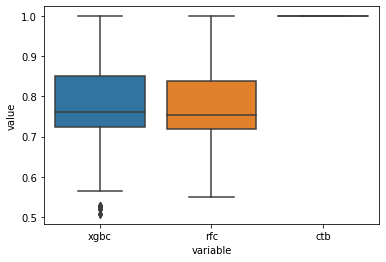

In [24]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'xgbc':shap_xgbc_stability,'rfc':shap_rfc_stability,'ctb':shap_ctb_stability})))

<AxesSubplot:xlabel='variable', ylabel='value'>

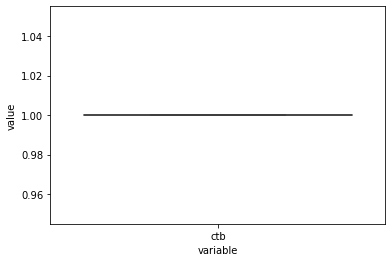

In [25]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'ctb':shap_ctb_stability})))

### Area under the ACCLOSS

In [132]:
xgbc_perm = PermutationImportance(xgbc, random_state=1).fit(X_test, y_test)
xgbc_perm_importances = xgbc_perm.feature_importances_
show_weights(xgbc_perm, feature_names=FEATURE_IDS)

Weight,Feature
0.0846 ± 0.0150,0
0.0442 ± 0.0100,1
0.0247 ± 0.0102,3
0.0057 ± 0.0074,9
0.0041 ± 0.0040,4
0.0034 ± 0.0070,10
0.0027 ± 0.0045,2
0.0005 ± 0.0011,5
0.0003 ± 0.0025,8
-0.0002 ± 0.0005,7


In [133]:
xgbc_perm

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=48,
                                              num_parallel_tree=1,
                                              random_state=0, reg_alpha=0,
                                      

In [134]:
xgbc_perm_importances

array([ 0.08463427,  0.04418262,  0.00274914,  0.02474227,  0.00412371,
        0.00049092, -0.00049092, -0.00019637,  0.00029455,  0.00569465,
        0.00343643])

In [130]:
rfc_perm = PermutationImportance(rfc, random_state=1).fit(X_test, y_test)
rfc_perm_importances = rfc_perm.feature_importances_
show_weights(rfc_perm, feature_names=FEATURE_IDS)

Weight,Feature
0.0917 ± 0.0076,0
0.0406 ± 0.0147,1
0.0246 ± 0.0099,3
0.0116 ± 0.0064,9
0.0098 ± 0.0051,2
0.0079 ± 0.0067,4
0.0073 ± 0.0068,10
0.0002 ± 0.0005,5
0.0000 ± 0.0006,7
-0.0017 ± 0.0053,8


In [129]:
ctb_perm = PermutationImportance(ctb, random_state=1).fit(X_test, y_test)
ctb_perm_importances = ctb_perm.feature_importances_
show_weights(ctb_perm, feature_names=FEATURE_IDS)

Weight,Feature
0.0879 ± 0.0134,0
0.0348 ± 0.0080,1
0.0224 ± 0.0086,3
0.0052 ± 0.0058,2
0.0042 ± 0.0046,9
0.0014 ± 0.0024,8
0.0011 ± 0.0061,10
0.0011 ± 0.0018,6
0.0004 ± 0.0014,5
0.0001 ± 0.0033,4


In [29]:
ct = ColumnTransformer([('_INXAI_categorical_noise_perturber', CategoricalNoisePerturber(),X_test.columns)])


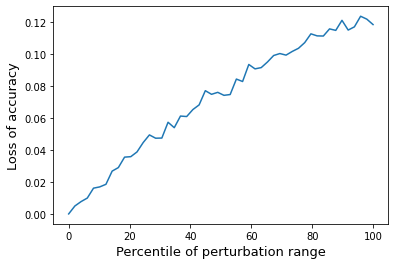

In [30]:
shap_xgbc_acc_loss = gm.gradual_perturbation(model = xgbc, X = X_test, y = y_test, column_transformer = ct, importances_orig = xgbc_perm_importances, resolution=50,  count_per_step=10)
to_pickle(shap_xgbc_acc_loss, 'shap_xgbc_acc_loss')
# shap_xgbc_acc_loss = from_pickle('shap_xgbc_acc_loss')

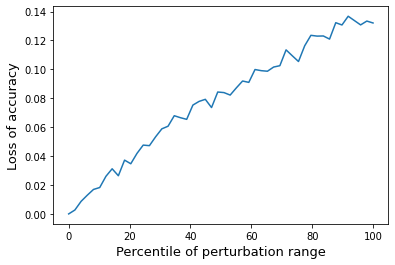

In [38]:
shap_rfc_acc_loss = gm.gradual_perturbation(model = rfc, X = X_test, y = y_test, column_transformer = ct, importances_orig = rfc_perm_importances, resolution=50,  count_per_step=10)
to_pickle(shap_rfc_acc_loss, 'shap_rfc_acc_loss')


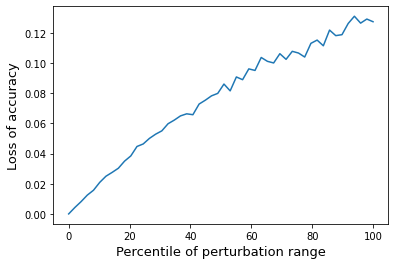

In [39]:
shap_ctb_acc_loss = gm.gradual_perturbation(model = ctb, X = X_test, y = y_test, column_transformer = ct, importances_orig = ctb_perm_importances, resolution=50,  count_per_step=10)
to_pickle(shap_ctb_acc_loss, 'shap_ctb_acc_loss')


In [37]:
shap_xgbc_acc_loss = from_pickle('shap_xgbc_acc_loss')
shap_rfc_acc_loss = from_pickle('shap_rfc_acc_loss')
shap_ctb_acc_loss = from_pickle('shap_ctb_acc_loss')

In [40]:
print(approximateAreaUnderTheCurveAccLoss(shap_xgbc_acc_loss))
print(approximateAreaUnderTheCurveAccLoss(shap_rfc_acc_loss))
print(approximateAreaUnderTheCurveAccLoss(shap_ctb_acc_loss))

0.07203927344133533
0.07837309769268536
0.07605891016200297


In [50]:
print(AreaUnderTheCurve(shap_xgbc_acc_loss))
print(AreaUnderTheCurve(shap_rfc_acc_loss))
print(AreaUnderTheCurve(shap_ctb_acc_loss))

0.07230170418682935
0.0786245278671115
0.07631070101089034


# SHAP's optimization

## stability X acc_loss_area : xgbc

approximateAreaUnderTheCurveAccLoss : *_perm_importances -> 11        # gm.gradual_perturbation(model = *, X = X_test, y = y_test ....
stability                           : shap -> N * 11                  # gm.stability(X_test, shap_xgbc ,epsilon=0.3)
consistency                         : shap -> m * N * 11              # gm.consistency([shap_xgbc, shap_rfc, shap_ctb])

In [47]:
pd.DataFrame(shap_xgbc).describe() 

,0,1,2,3,4,5,6,7,8,9,10
count,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000
mean,0.046514,0.020542,0.004184,0.009355,0.001812,0.000195,0.000521,0.000047,0.000078,0.002836,0.002346
std,0.146039,0.074462,0.030757,0.072299,0.019998,0.004274,0.012779,0.007310,0.010729,0.041253,0.026792
min,-0.525536,-0.174603,-0.146789,-0.195943,-0.090036,-0.021019,-0.143798,-0.212135,-0.149128,-0.201674,-0.199312
25%,-0.065873,-0.056670,-0.012706,-0.037206,-0.011413,-0.000293,-0.001625,-0.000276,-0.001536,-0.017171,-0.012917
50%,0.078529,0.050414,0.004261,0.024970,0.001230,-0.000003,0.000551,-0.000219,-0.000208,-0.000494,0.002986
75%,0.142344,0.079465,0.017811,0.046136,0.014820,0.000224,0.002432,0.000287,0.000952,0.020064,0.017034
max,0.536899,0.148204,0.152164,0.227201,0.090036,0.112828,0.132552,0.198241,0.119722,0.201674,0.117488


In [ ]:
pd.DataFrame(xgbc_perm_importances).T

## Weights for SHAP

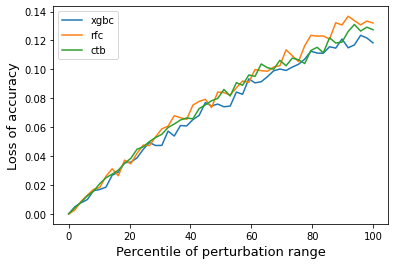

In [51]:
plt.plot(np.linspace(0, 100, 50), shap_xgbc_acc_loss)
plt.plot(np.linspace(0, 100, 50), shap_rfc_acc_loss)
plt.plot(np.linspace(0, 100, 50), shap_ctb_acc_loss)
plt.xlabel('Percentile of perturbation range', fontsize=13)
plt.ylabel('Loss of accuracy', fontsize=13)
plt.legend(['xgbc','rfc','ctb'])

In [85]:
w_xgbc = 1 / np.mean([np.linalg.norm(x) for x in shap_xgbc])
w_rfc = 1 / np.mean([np.linalg.norm(x) for x in shap_rfc])
w_ctb = 1 / np.mean([np.linalg.norm(x) for x in shap_ctb])

print(w_xgbc,w_rfc,w_ctb)

5.397124401075258 5.145980641841641 1.1160088617378467


### weighted model

In [184]:
class weighted_model:
    def __init__(self, w1, m1, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None):
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.colnames = None
        
    def predict(self, X):
        weighted_proba = self.predict_proba(X)
        return [0 if wp[0] > 0.5 else 1 for wp in weighted_proba]
    
    def predict_proba(self, X):
        w_ = self.w1 + self.w2 + self.w3
        m2_predict_proba = 0.0 if self.w2 == 0.0 else self.m2.predict_proba(X)
        m3_predict_proba = 0.0 if self.w3 == 0.0 else self.m3.predict_proba(X)
        weighted_prediction = (self.w1 * self.m1.predict_proba(X) + self.w2 * m2_predict_proba + self.w3 * m3_predict_proba) / w_
        return weighted_prediction

    def fit(self, X):
        self.colnames = X.columns
        return self


In [173]:
weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctb, m3=ctb).predict_proba(X_test)[0]

array([0.07040712, 0.92959287])

In [175]:
weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctb, m3=ctb).predict(X_test)[0]

1

### weighted Permutation Importance

In [176]:
weighted_perm = PermutationImportance(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctb, m3=ctb), random_state=42, scoring="accuracy").fit(X_test, y_test)
weighted_perm_importances = weighted_perm.feature_importances_
show_weights(weighted_perm, feature_names=FEATURE_IDS)

Weight,Feature
0.0788 ± 0.0184,0
0.0381 ± 0.0043,1
0.0245 ± 0.0054,3
0.0105 ± 0.0086,9
0.0066 ± 0.0058,2
0.0038 ± 0.0055,4
0.0005 ± 0.0035,8
0 ± 0.0000,7
-0.0005 ± 0.0014,5
-0.0023 ± 0.0068,10


### weighted AUC for Accuracy Loss

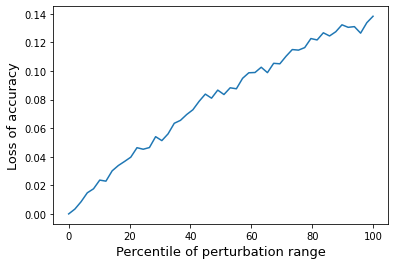

In [142]:
ct = ColumnTransformer([('_INXAI_categorical_noise_perturber', CategoricalNoisePerturber(),X_test.columns)])

def weighted_acc_loss(w_xgbc, w_rfc, w_ctb):
    return gm.gradual_perturbation(model = weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctb, m3=ctb), X = X_test, y = y_test, column_transformer = ct, importances_orig = weighted_perm_importances, resolution=50,  count_per_step=10)

weighted_acc_loss = weighted_acc_loss(w_xgbc, w_rfc, w_ctb)

In [157]:
auc_shap_xgbc_acc_loss = AreaUnderTheCurve(shap_xgbc_acc_loss)
auc_shap_rfc_acc_loss = AreaUnderTheCurve(shap_rfc_acc_loss)
auc_shap_ctb_acc_loss = AreaUnderTheCurve(shap_ctb_acc_loss)

print(auc_shap_xgbc_acc_loss)
print(auc_shap_rfc_acc_loss)
print(auc_shap_ctb_acc_loss)

print("Naive vs from weighted model:")
print((w_xgbc * auc_shap_xgbc_acc_loss + w_rfc * auc_shap_rfc_acc_loss + w_ctb * auc_shap_ctb_acc_loss) / (w_xgbc + w_rfc + w_ctb) )
print(AreaUnderTheCurve(weighted_acc_loss))

0.07230170418682935
0.0786245278671115
0.07631070101089034
Naive vs from weighted model:
0.07547614819222367
0.07958382174666623


## weighted shap

In [196]:
def weighted_shap_naive(w1, shap1, w2 = 0.0, shap2 = None, w3 = 0.0, shap3 = None):
    w_ = w1 + w2 + w3
    
    shapNone = [shap_i * 0.0 for shap_i in shap1]
    
    shap1_w = [shap_i * w1 for shap_i in shap1]
    shap2_w = shapNone if w2 == 0.0 else [shap_i * w2 for shap_i in shap2]
    shap3_w = shapNone if w3 == 0.0 else [shap_i * w3 for shap_i in shap3]
    
    shap_zip =  zip(shap1_w, shap2_w, shap3_w)
    
    return [(shap1_w_i + shap2_w_i + shap3_w_i) / w_ for shap1_w_i, shap2_w_i, shap3_w_i in shap_zip]


In [199]:
weighted_xgbc_rfc_ctb_shap_naive = weighted_shap_naive(w1=w_xgbc, shap1=shap_xgbc, w2=w_rfc, shap2=shap_rfc, w3=w_ctb, shap3=shap_ctb)
print(len(weighted_xgbc_rfc_ctb_shap_naive))

2037


In [ ]:
weighted_xgbc_rfc_ctb_shap = generate_per_instance_importances(models=weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctb, m3=ctb), X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='kernel_shap') 
to_pickle(weighted_xgbc_rfc_ctb_shap, 'weighted_xgbc_rfc_ctb_shap')
print(len(weighted_xgbc_rfc_ctb_shap))

Using 2037 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2037 [00:00<?, ?it/s]

## Stability

In [200]:
weighted_xgbc_rfc_ctb_stability_naive = gm.stability(X_test, weighted_xgbc_rfc_ctb_shap_naive ,epsilon=0.3)
to_pickle(weighted_xgbc_rfc_ctb_stability_naive, 'weighted_xgbc_rfc_ctb_stability_naive')
# weighted_xgbc_rfc_ctb_stability_naive = from_pickle('weighted_xgbc_rfc_ctb_stability_naive')


In [ ]:
weighted_xgbc_rfc_ctb_stability = gm.stability(X_test, weighted_xgbc_rfc_ctb_shap ,epsilon=0.3)
to_pickle(weighted_xgbc_rfc_ctb_stability, 'weighted_xgbc_rfc_ctb_stability')
# weighted_xgbc_rfc_ctb_stability = from_pickle('weighted_xgbc_rfc_ctb_stability')


In [ ]:
1 + 1

### Consistency

In [ ]:
weighted_xgbc_rfc_ctb_consistency = gm.consistency(weighted_xgbc_rfc_ctb_shap) 
to_pickle(shap_weighted_xgbc_rfc_ctb_consistency, 'shap_weighted_xgbc_rfc_ctb_consistency')
# shap_weighted_xgbc_rfc_ctb_consistency = from_pickle('shap_weighted_xgbc_rfc_ctb_consistency')
len(shap_weighted_xgbc_rfc_ctb_consistency)
shap_weighted_xgbc_rfc_ctb_consistency

In [148]:
def weighted_consistency(w_xgbc, w_rfc, w_ctb):
    w_ = w_xgbc + w_rfc + w_ctb
    return gm.consistency([w_xgbc * shap_xgbc / w_,  w_rfc * shap_rfc / w_, w_ctb * shap_ctb / w_])

weighted_consistency(w_xgbc, w_rfc, w_ctb)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

## SMAC 
- https://automl.github.io/SMAC3/master/examples/SMAC4BO_rosenbrock.html#sphx-glr-examples-smac4bo-rosenbrock-py 
- https://automl.github.io/SMAC3/master/examples/SMAC4HPO_rosenbrock.html#sphx-glr-examples-smac4hpo-rosenbrock-py